# Gray's Reef NMS Environmental Data Analysis

This notebook demonstrates how to download and analyze oceanographic data from NOAA CoastWatch ERDDAP servers for **Gray's Reef National Marine Sanctuary** (Georgia coast).

## Datasets
| Variable | Source | Resolution | Time Range |
|----------|--------|------------|------------|
| **Sea Surface Temperature (SST)** | Coral Reef Watch v3.1 | 5 km | 2003-present |
| **SST Anomaly** | Coral Reef Watch v3.1 | 5 km | 2003-present |
| **K490 (Turbidity)** | MODIS Aqua | 4 km | 2003-present |
| **Chlorophyll-a** | VIIRS Science Quality | 750 m | 2012-present |

## Study Area
Gray's Reef NMS is located off the Georgia coast:
- Latitude: 31.36°N to 31.42°N
- Longitude: 80.82°W to 80.93°W

---
## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import requests
from datetime import datetime
import os

# Cartopy for mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Shapely for polygon operations
from shapely.geometry import Point, Polygon

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully!")

Libraries loaded successfully!


---
## 2. Define Study Area

In [ ]:
# Gray's Reef NMS official polygon coordinates
POLYGON_COORDS = [
    (31.362732, -80.921200),
    (31.421064, -80.921201),
    (31.421064, -80.828145),
    (31.362732, -80.828145),
    (31.362732, -80.921200)  # closes polygon
]

# Convert to (lon, lat) format for shapely
POLYGON_LONLAT = [(lon, lat) for lat, lon in POLYGON_COORDS]

# Bounding box (for ERDDAP queries)
BOUNDS = {
    'lat_min': 31.36,
    'lat_max': 31.42,
    'lon_min': -80.93,
    'lon_max': -80.82
}

# Center point
center_lat = (BOUNDS['lat_min'] + BOUNDS['lat_max']) / 2
center_lon = (BOUNDS['lon_min'] + BOUNDS['lon_max']) / 2

# Time ranges - extended for full analysis
# SST & K490: 2003-present, Chlorophyll: 2012-present
TIME_RANGES = {
    'sst': {'start': '2003-01-01', 'end': '2024-12-31'},
    'k490': {'start': '2003-01-01', 'end': '2024-12-31'},
    'chlorophyll': {'start': '2012-01-01', 'end': '2024-12-31'}
}

# Output directory
OUTPUT_DIR = './grays_reef_data'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Gray's Reef NMS Polygon Coordinates:")
print("-" * 40)
for i, (lat, lon) in enumerate(POLYGON_COORDS[:-1]):
    print(f"  Corner {i+1}: {lat:.6f}°N, {abs(lon):.6f}°W")
print(f"\nBounding Box: {BOUNDS['lat_min']}-{BOUNDS['lat_max']}°N, {abs(BOUNDS['lon_max'])}-{abs(BOUNDS['lon_min'])}°W")
print(f"\nTime Ranges:")
for key, tr in TIME_RANGES.items():
    print(f"  {key.upper()}: {tr['start']} to {tr['end']}")

### 2.1 Study Area Map

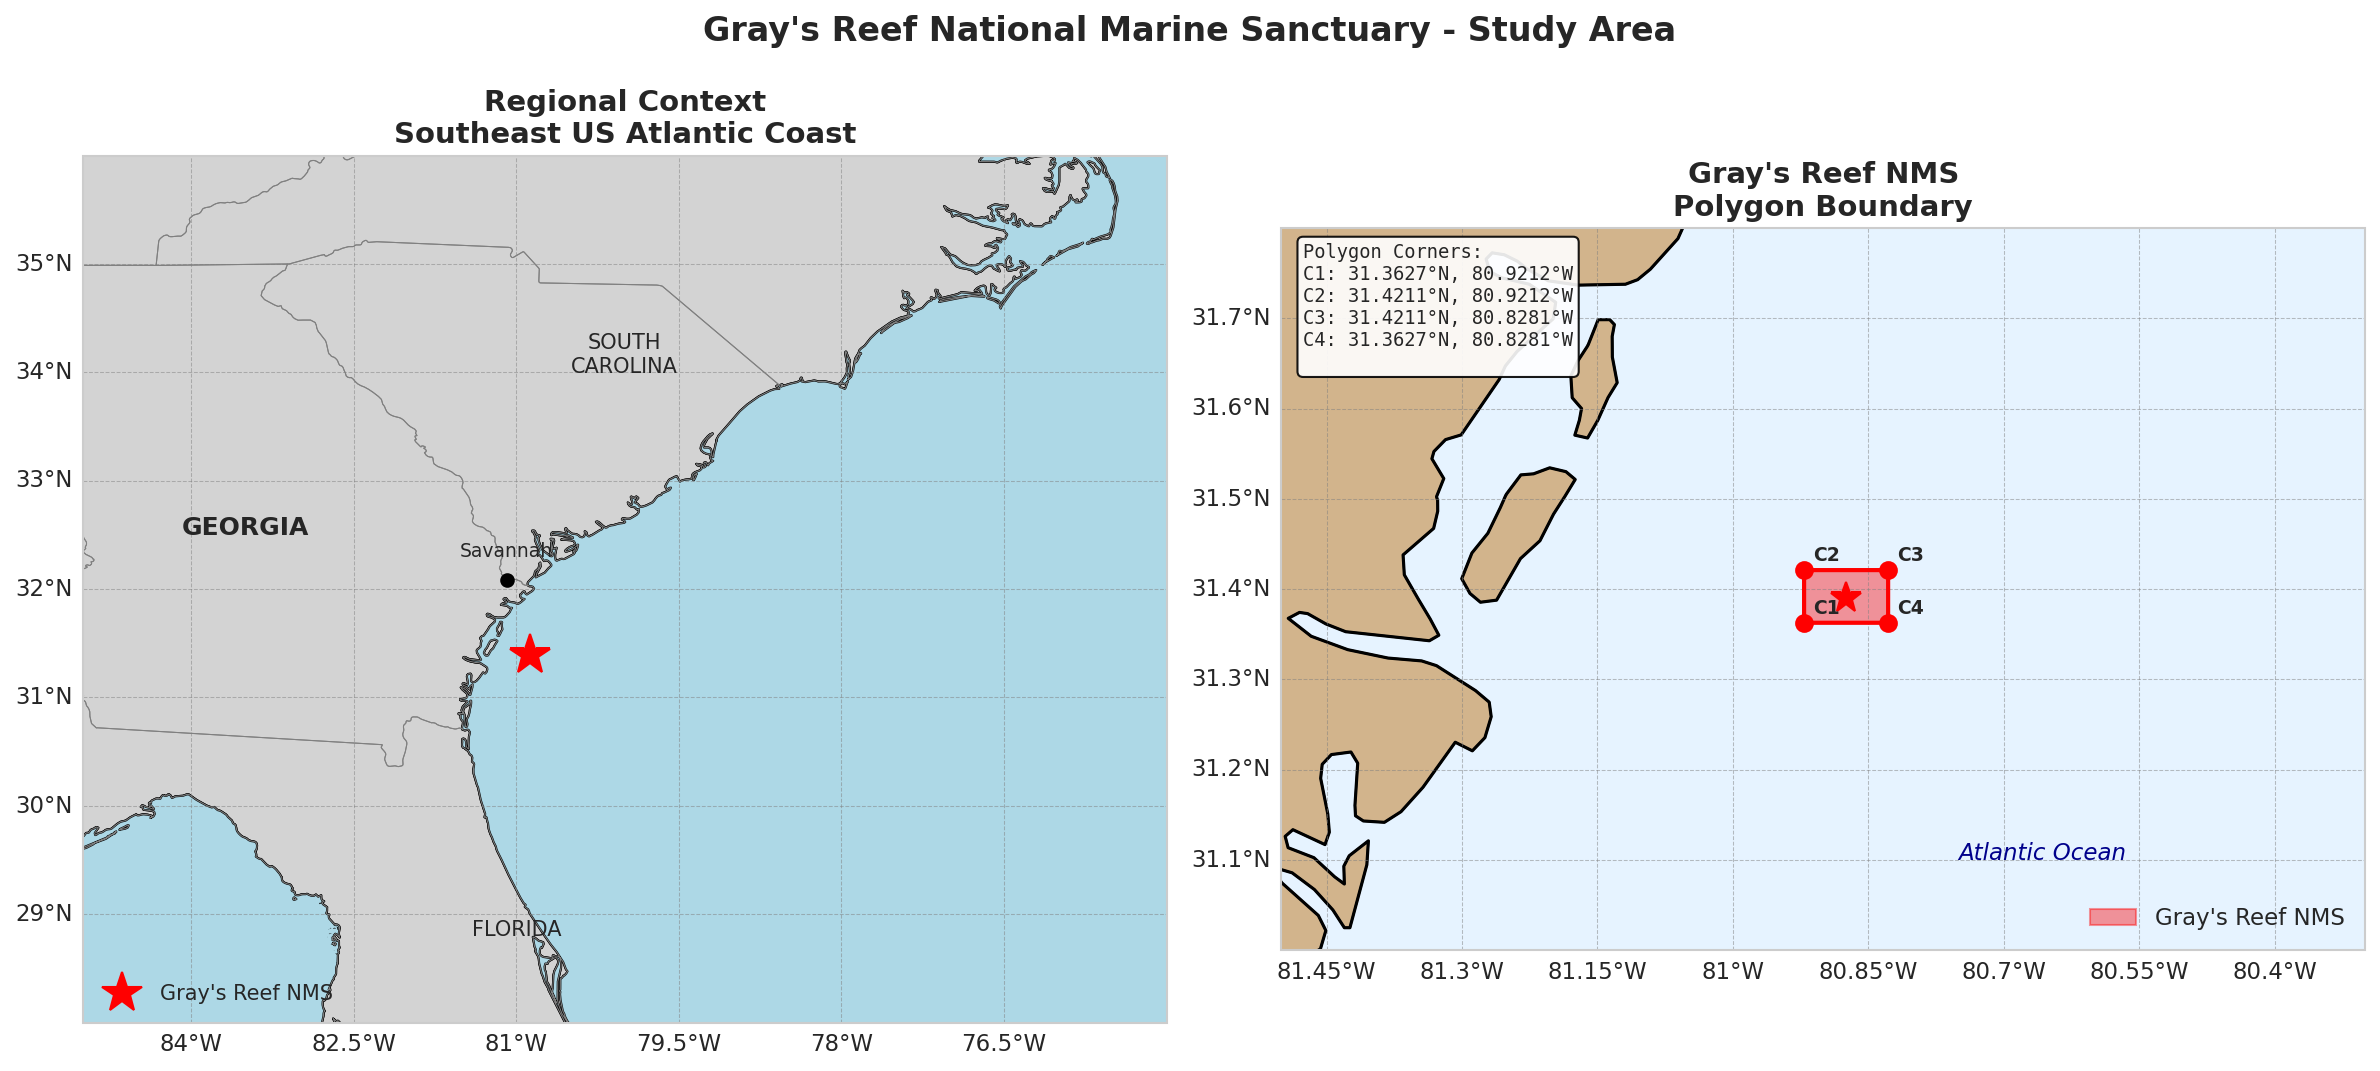

In [1]:
# Create figure with two maps
fig = plt.figure(figsize=(16, 7))

# Map 1: Regional Context
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-85, -75, 28, 36], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
ax1.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax1.add_feature(cfeature.COASTLINE, linewidth=1)
ax1.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray')

gl1 = ax1.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

# Mark Gray's Reef
ax1.plot(center_lon, center_lat, 'r*', markersize=20, transform=ccrs.PlateCarree(), 
         label="Gray's Reef NMS", zorder=10)

# State labels
ax1.text(-83.5, 32.5, 'GEORGIA', fontsize=12, fontweight='bold', ha='center', transform=ccrs.PlateCarree())
ax1.text(-80, 34, 'SOUTH\nCAROLINA', fontsize=10, ha='center', transform=ccrs.PlateCarree())
ax1.text(-81, 28.8, 'FLORIDA', fontsize=10, ha='center', transform=ccrs.PlateCarree())

ax1.plot(-81.09, 32.08, 'ko', markersize=6, transform=ccrs.PlateCarree())
ax1.text(-81.09, 32.3, 'Savannah', fontsize=9, ha='center', transform=ccrs.PlateCarree())
ax1.set_title('Regional Context\nSoutheast US Atlantic Coast', fontsize=14, fontweight='bold')
ax1.legend(loc='lower left', fontsize=10)

# Map 2: Zoomed with polygon
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([-81.5, -80.3, 31.0, 31.8], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.OCEAN, facecolor='#E6F3FF')
ax2.add_feature(cfeature.LAND, facecolor='#D2B48C', edgecolor='black')
ax2.add_feature(cfeature.COASTLINE, linewidth=1.5)

gl2 = ax2.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

# Plot polygon
poly_lons = [c[1] for c in POLYGON_COORDS]
poly_lats = [c[0] for c in POLYGON_COORDS]
ax2.fill(poly_lons, poly_lats, color='red', alpha=0.4, transform=ccrs.PlateCarree(),
         label="Gray's Reef NMS")
ax2.plot(poly_lons, poly_lats, 'r-', linewidth=2, transform=ccrs.PlateCarree())

# Mark corners
for i, (lat, lon) in enumerate(POLYGON_COORDS[:-1]):
    ax2.plot(lon, lat, 'ro', markersize=8, transform=ccrs.PlateCarree())
    ax2.text(lon + 0.01, lat + 0.01, f'C{i+1}', fontsize=9, fontweight='bold', transform=ccrs.PlateCarree())

ax2.plot(center_lon, center_lat, 'r*', markersize=15, transform=ccrs.PlateCarree())
ax2.text(-80.75, 31.1, 'Atlantic Ocean', fontsize=11, fontstyle='italic', color='darkblue', transform=ccrs.PlateCarree())

# Info box
coord_text = "Polygon Corners:\n"
for i, (lat, lon) in enumerate(POLYGON_COORDS[:-1]):
    coord_text += f"C{i+1}: {lat:.4f}°N, {abs(lon):.4f}°W\n"
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
ax2.text(0.02, 0.98, coord_text, transform=ax2.transAxes, fontsize=9,
         verticalalignment='top', bbox=props, family='monospace')

ax2.set_title("Gray's Reef NMS\nPolygon Boundary", fontsize=14, fontweight='bold')
ax2.legend(loc='lower right')

plt.suptitle("Gray's Reef National Marine Sanctuary - Study Area", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/study_area_map.png", dpi=150, bbox_inches='tight')
plt.show()

### 2.2 Polygon Masking Function

ERDDAP only supports rectangular bounding boxes. For exact polygon subsetting, we apply masking in post-processing.

In [4]:
def mask_to_polygon(df, polygon_coords, lat_col='latitude', lon_col='longitude'):
    """
    Filter dataframe to only include points inside a polygon.
    
    Parameters:
    -----------
    df : pandas.DataFrame - Data with lat/lon columns
    polygon_coords : list - List of (lon, lat) tuples defining polygon
    lat_col, lon_col : str - Column names for coordinates
    
    Returns:
    --------
    pandas.DataFrame - Filtered to points inside polygon
    """
    polygon = Polygon(polygon_coords)
    
    mask = df.apply(
        lambda row: polygon.contains(Point(row[lon_col], row[lat_col])), 
        axis=1
    )
    
    df_masked = df[mask].copy()
    print(f"Polygon masking: {len(df)} → {len(df_masked)} points ({len(df)-len(df_masked)} outside polygon)")
    
    return df_masked

print("Polygon masking function defined.")
print("\nNote: Gray's Reef polygon is rectangular, so bounding box ≈ polygon.")

Polygon masking function defined.

Note: Gray's Reef polygon is rectangular, so bounding box ≈ polygon.


---
## 3. ERDDAP Data Access

ERDDAP provides a REST API for oceanographic data.

**URL Structure:**
```
https://{server}/erddap/griddap/{dataset_id}.{format}?{variable}[{time}][{lat}][{lon}]
```

### Data Sources Used in This Notebook

| Dataset | Server | Dataset ID | Variables | Period |
|---------|--------|------------|-----------|--------|
| SST & Anomaly | coastwatch.pfeg.noaa.gov | NOAA_DHW_monthly | sea_surface_temperature, sea_surface_temperature_anomaly | 2003-2024 |
| K490 Turbidity | coastwatch.pfeg.noaa.gov | erdMH1kd490mday_R2022SQ | Kd_490 | 2003-2024 |
| Chlorophyll-a | coastwatch.noaa.gov | noaacwNPPVIIRSSQchlaMonthly | chlor_a | 2012-2024 |

### Alternative SST Data Sources

| Dataset ID | Name | Resolution | Period | Best For |
|------------|------|------------|--------|----------|
| `NOAA_DHW_monthly` | Coral Reef Watch (used here) | 5 km | 1985-present | Coral bleaching, anomalies |
| `jplMURSST41` | MUR SST | 1 km | 2002-present | High-resolution analysis |
| `erdMH1sstdmday` | MODIS Aqua Monthly | 4 km | 2003-present | Long-term satellite record |
| `nceiErsstv5` | NOAA ERSST v5 | 2° | 1854-present | Climate studies |

In [ ]:
DATASETS = {
    'sst': {
        'name': 'Sea Surface Temperature & Anomaly (Coral Reef Watch)',
        'server': 'https://coastwatch.pfeg.noaa.gov/erddap',
        'dataset_id': 'NOAA_DHW_monthly',
        'variables': ['sea_surface_temperature', 'sea_surface_temperature_anomaly'],
        'has_altitude': False,
        'lat_ascending': False,  # Latitude order in dataset
    },
    'k490': {
        'name': 'K490 Turbidity (MODIS Aqua)',
        'server': 'https://coastwatch.pfeg.noaa.gov/erddap',
        'dataset_id': 'erdMH1kd490mday_R2022SQ',
        'variables': ['Kd_490'],
        'has_altitude': False,
        'lat_ascending': True,
    },
    'chlorophyll': {
        'name': 'Chlorophyll-a (VIIRS Science Quality)',
        'server': 'https://coastwatch.noaa.gov/erddap',
        'dataset_id': 'noaacwNPPVIIRSSQchlaMonthly',
        'variables': ['chlor_a'],
        'has_altitude': True,
        'lat_ascending': True,
    },
}

def build_erddap_url(server, dataset_id, variables, time_start, time_end, bounds, 
                     has_altitude=False, lat_ascending=True):
    """Build ERDDAP griddap URL for data download."""
    base_url = f"{server}/griddap/{dataset_id}.csv"
    time_constraint = f"[({time_start}T12:00:00Z):1:({time_end}T12:00:00Z)]"
    
    # Some datasets have altitude dimension
    alt_constraint = "[(0.0)]" if has_altitude else ""
    
    # Latitude order varies by dataset
    if lat_ascending:
        lat_constraint = f"[({bounds['lat_min']}):1:({bounds['lat_max']})]"
    else:
        lat_constraint = f"[({bounds['lat_max']}):1:({bounds['lat_min']})]"
    
    lon_constraint = f"[({bounds['lon_min']}):1:({bounds['lon_max']})]"
    
    var_queries = [f"{var}{time_constraint}{alt_constraint}{lat_constraint}{lon_constraint}" for var in variables]
    return f"{base_url}?{','.join(var_queries)}"

def download_erddap_chunked(dataset_key, time_start, time_end, chunk_years=5):
    """Download data in chunks to avoid timeouts for long time series."""
    from io import StringIO
    
    ds = DATASETS[dataset_key]
    all_data = []
    
    # Create year chunks
    start_year = int(time_start[:4])
    end_year = int(time_end[:4])
    
    for chunk_start in range(start_year, end_year + 1, chunk_years):
        chunk_end = min(chunk_start + chunk_years - 1, end_year)
        t_start = f"{chunk_start}-01-01"
        t_end = f"{chunk_end}-12-31"
        
        print(f"  Downloading {t_start} to {t_end}...")
        
        url = build_erddap_url(
            ds['server'], ds['dataset_id'], ds['variables'],
            t_start, t_end, BOUNDS,
            has_altitude=ds.get('has_altitude', False),
            lat_ascending=ds.get('lat_ascending', True)
        )
        
        try:
            response = requests.get(url, timeout=300)
            if response.status_code == 200:
                df = pd.read_csv(StringIO(response.text), skiprows=[1])
                all_data.append(df)
                print(f"    Got {len(df)} records")
            else:
                print(f"    Error {response.status_code}: {response.text[:100]}")
        except Exception as e:
            print(f"    Exception: {e}")
    
    if all_data:
        df_combined = pd.concat(all_data, ignore_index=True)
        df_combined['time'] = pd.to_datetime(df_combined['time'])
        df_combined = df_combined.sort_values('time').drop_duplicates()
        print(f"  Total: {len(df_combined)} records")
        return df_combined
    return None

print("ERDDAP functions defined.")
print(f"\nDatasets configured:")
for key, ds in DATASETS.items():
    print(f"  - {ds['name']}")
    print(f"    Server: {ds['server'].split('//')[1].split('/')[0]}")
    print(f"    Dataset: {ds['dataset_id']}")

---
## 4. Download Data

In [ ]:
# Download SST (2003-2024)
print("="*60)
print("SST Data (Coral Reef Watch) - 2003-2024")
print("="*60)

sst_raw = download_erddap_chunked('sst', 
                                  TIME_RANGES['sst']['start'], 
                                  TIME_RANGES['sst']['end'],
                                  chunk_years=6)

if sst_raw is not None:
    # Apply polygon masking
    sst_raw = mask_to_polygon(sst_raw, POLYGON_LONLAT)
    sst_raw.to_csv(f"{OUTPUT_DIR}/sst_raw.csv", index=False)
    display(sst_raw.head())

In [ ]:
# Download K490 (MODIS Aqua 2003-2024)
print("="*60)
print("K490 Data (MODIS Aqua) - 2003-2024")
print("="*60)

k490_raw = download_erddap_chunked('k490',
                                   TIME_RANGES['k490']['start'],
                                   TIME_RANGES['k490']['end'],
                                   chunk_years=6)

if k490_raw is not None:
    # Rename column to lowercase for consistency
    if 'Kd_490' in k490_raw.columns:
        k490_raw = k490_raw.rename(columns={'Kd_490': 'kd_490'})
    
    # Apply polygon masking
    k490_raw = mask_to_polygon(k490_raw, POLYGON_LONLAT)
    k490_raw.to_csv(f"{OUTPUT_DIR}/k490_raw.csv", index=False)
    display(k490_raw.head())

In [ ]:
# Download Chlorophyll-a (VIIRS 2012-2024)
print("="*60)
print("Chlorophyll-a Data (VIIRS Science Quality) - 2012-2024")
print("="*60)

chla_raw = download_erddap_chunked('chlorophyll',
                                   TIME_RANGES['chlorophyll']['start'],
                                   TIME_RANGES['chlorophyll']['end'],
                                   chunk_years=4)

if chla_raw is not None:
    # Apply polygon masking
    chla_raw = mask_to_polygon(chla_raw, POLYGON_LONLAT)
    chla_raw.to_csv(f"{OUTPUT_DIR}/chlorophyll_raw.csv", index=False)
    display(chla_raw.head())

---
## 5. Process Data

In [ ]:
def process_to_timeseries(df):
    """Aggregate gridded data to time series by spatial averaging."""
    df = df.copy()
    df['time'] = pd.to_datetime(df['time'])
    data_cols = [c for c in df.columns if c not in ['time', 'latitude', 'longitude']]
    ts = df.groupby('time')[data_cols].mean().reset_index()
    print(f"Aggregated {len(df):,} points → {len(ts):,} timesteps")
    return ts

# Process SST
print("Processing SST...")
sst = process_to_timeseries(sst_raw)
sst.to_csv(f"{OUTPUT_DIR}/sst_timeseries.csv", index=False)

# Process K490
print("\nProcessing K490...")
k490 = process_to_timeseries(k490_raw)
k490.to_csv(f"{OUTPUT_DIR}/k490_timeseries.csv", index=False)

# Process Chlorophyll-a
print("\nProcessing Chlorophyll-a...")
chla = process_to_timeseries(chla_raw)
chla.to_csv(f"{OUTPUT_DIR}/chlorophyll_timeseries.csv", index=False)

---
## 6. Summary Statistics

In [ ]:
print("SST Statistics")
print("-"*40)
print(f"Period: {sst['time'].min().strftime('%Y-%m-%d')} to {sst['time'].max().strftime('%Y-%m-%d')}")
print(f"Mean SST: {sst['sea_surface_temperature'].mean():.2f}°C")
print(f"Mean Anomaly: {sst['sea_surface_temperature_anomaly'].mean():.2f}°C")
print(f"SST Range: {sst['sea_surface_temperature'].min():.2f} - {sst['sea_surface_temperature'].max():.2f}°C")

print(f"\nChlorophyll-a Statistics")
print("-"*40)
print(f"Period: {chla['time'].min().strftime('%Y-%m-%d')} to {chla['time'].max().strftime('%Y-%m-%d')}")
print(f"Mean Chl-a: {chla['chlor_a'].mean():.3f} mg/m³")
print(f"Chl-a Range: {chla['chlor_a'].min():.3f} - {chla['chlor_a'].max():.3f} mg/m³")

print(f"\nK490 Statistics")
print("-"*40)
print(f"Period: {k490['time'].min().strftime('%Y-%m-%d')} to {k490['time'].max().strftime('%Y-%m-%d')}")
print(f"Mean K490: {k490['kd_490'].mean():.4f} m⁻¹")
print(f"K490 Range: {k490['kd_490'].min():.4f} - {k490['kd_490'].max():.4f} m⁻¹")

---
## 7. Visualizations

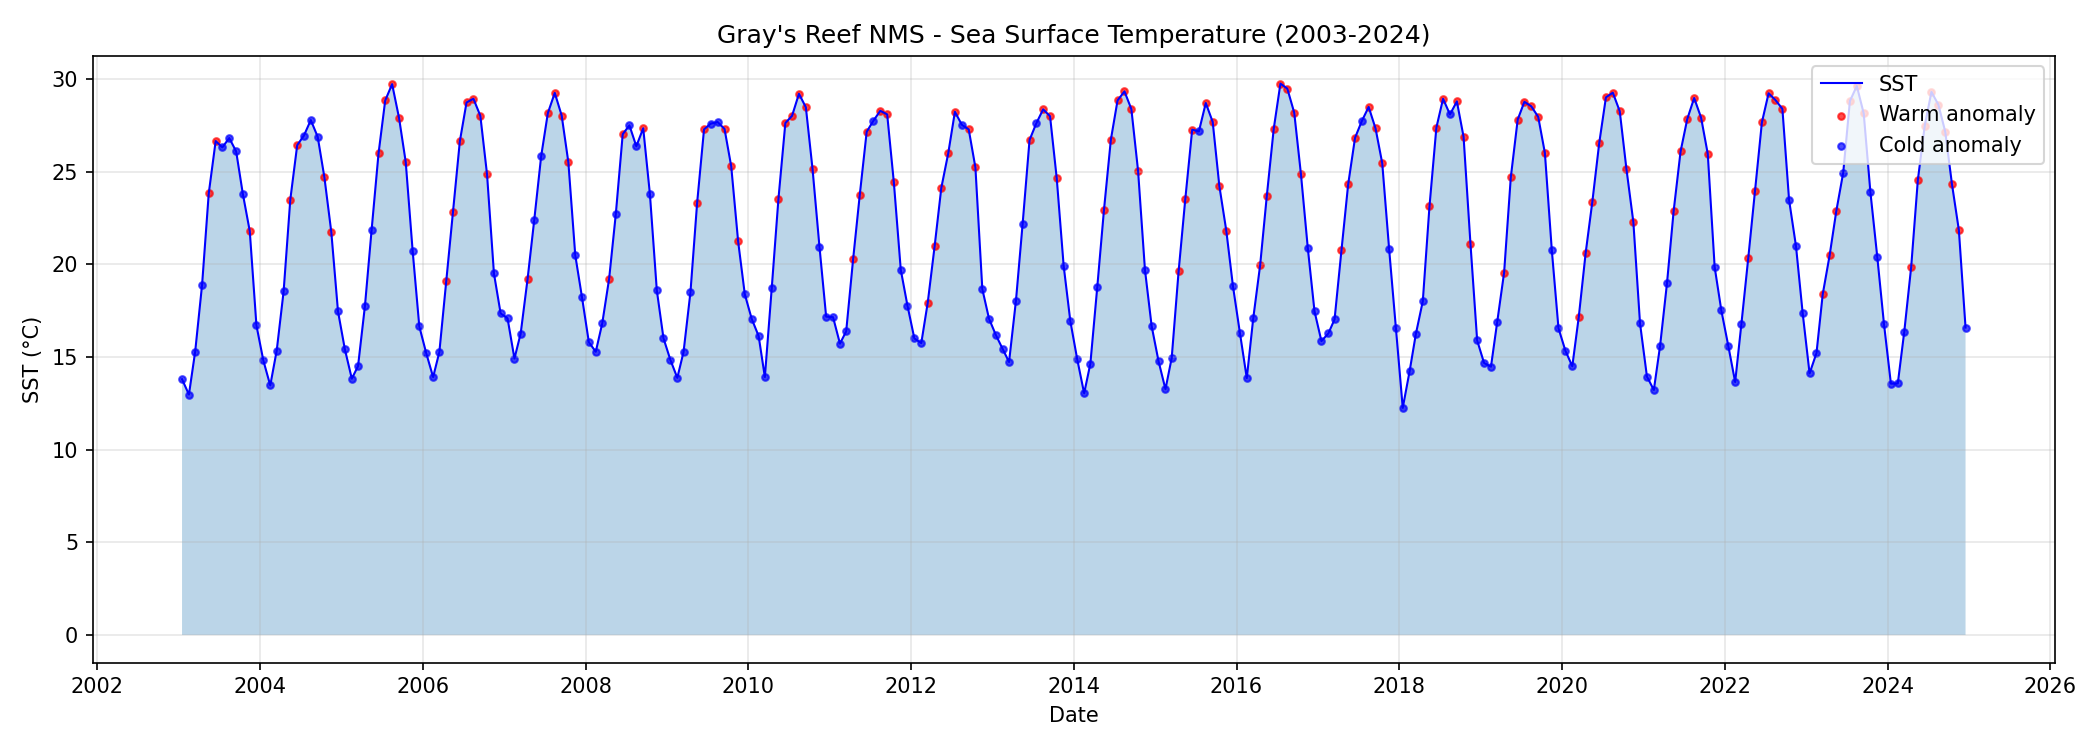

In [1]:
# SST Time Series (2003-2024)
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(sst['time'], sst['sea_surface_temperature'], 'b-', linewidth=1)
ax1.set_ylabel('SST (°C)', color='blue', fontsize=12)
ax1.set_ylim(10, 32)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.fill_between(sst['time'], 0, sst['sea_surface_temperature_anomaly'],
                 where=sst['sea_surface_temperature_anomaly'] >= 0, color='red', alpha=0.4, label='Warm')
ax2.fill_between(sst['time'], 0, sst['sea_surface_temperature_anomaly'],
                 where=sst['sea_surface_temperature_anomaly'] < 0, color='blue', alpha=0.4, label='Cold')
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax2.set_ylabel('Anomaly (°C)', color='gray', fontsize=12)
ax2.set_ylim(-7, 4)
ax2.legend(loc='upper right', title='Anomaly')

# Add trend line
sst['year_decimal'] = sst['time'].dt.year + sst['time'].dt.month/12
z = np.polyfit(sst['year_decimal'], sst['sea_surface_temperature'], 1)
trend_text = f"Trend: {z[0]:+.3f}°C/year"
ax1.text(0.02, 0.98, trend_text, transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax1.xaxis.set_major_locator(mdates.YearLocator(2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title("Gray's Reef NMS - Sea Surface Temperature (2003-2024)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plot_sst.png", dpi=150)
plt.show()

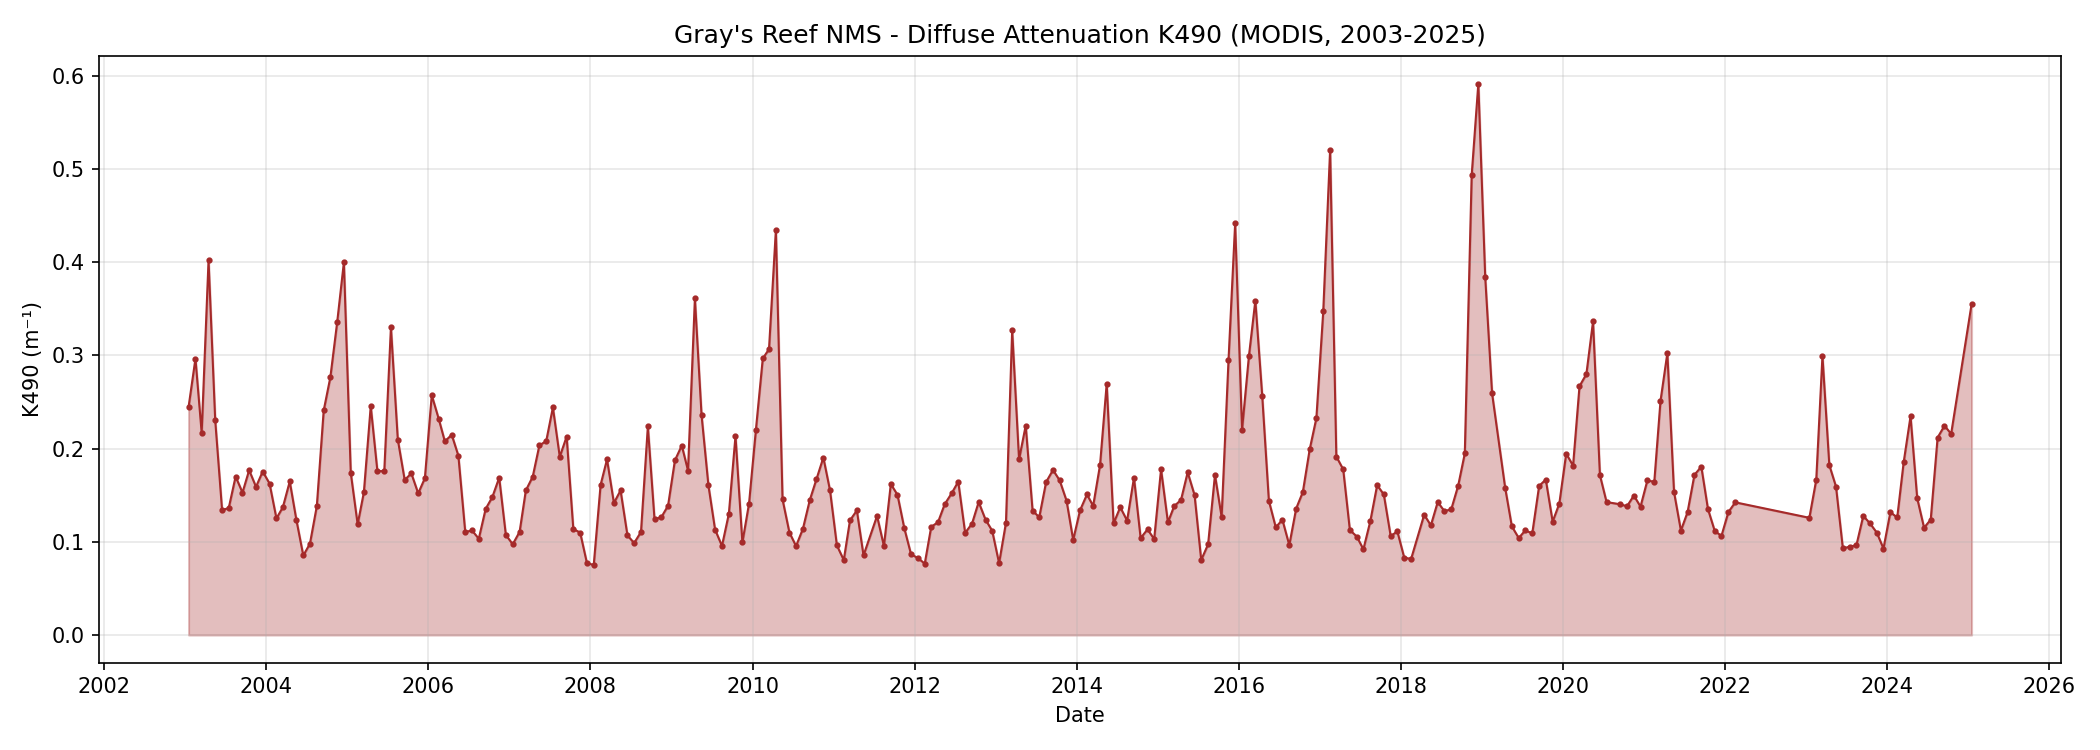

In [1]:
# K490 Time Series (2003-2024)
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(k490['time'], k490['kd_490'], 'brown', linewidth=1, marker='o', markersize=2)
ax.fill_between(k490['time'], 0, k490['kd_490'], color='brown', alpha=0.3)
ax.axhline(y=k490['kd_490'].mean(), color='darkred', linestyle='--', 
           label=f"Mean: {k490['kd_490'].mean():.3f} m⁻¹")

# Add trend
k490['year_decimal'] = k490['time'].dt.year + k490['time'].dt.month/12
z = np.polyfit(k490['year_decimal'], k490['kd_490'], 1)
trend_text = f"Trend: {z[0]:+.4f} m⁻¹/year"
ax.text(0.02, 0.98, trend_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax.set_ylabel('K490 (m⁻¹)', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_title("Gray's Reef NMS - Turbidity K490 (MODIS, 2003-2024)", fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plot_k490.png", dpi=150)
plt.show()

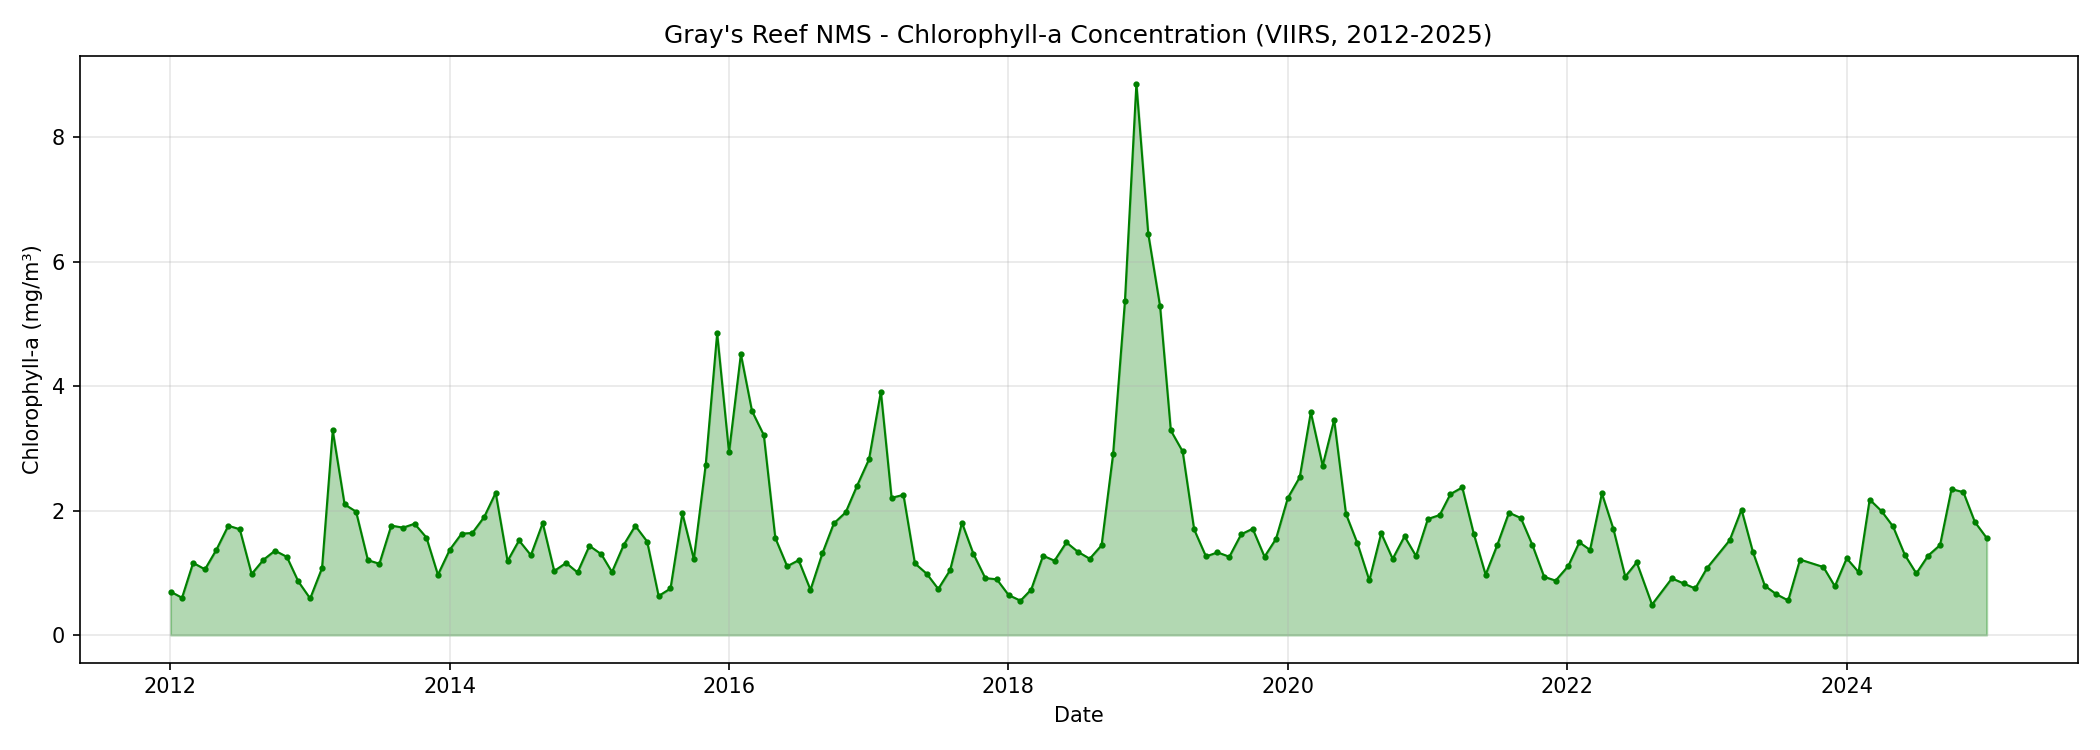

In [1]:
# Chlorophyll-a Time Series (2012-2024)
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(chla['time'], chla['chlor_a'], 'green', linewidth=1, marker='o', markersize=2)
ax.fill_between(chla['time'], 0, chla['chlor_a'], color='green', alpha=0.3)
ax.axhline(y=chla['chlor_a'].mean(), color='darkgreen', linestyle='--', 
           label=f"Mean: {chla['chlor_a'].mean():.2f} mg/m³")

# Add trend
chla['year_decimal'] = chla['time'].dt.year + chla['time'].dt.month/12
z = np.polyfit(chla['year_decimal'], chla['chlor_a'], 1)
trend_text = f"Trend: {z[0]:+.4f} mg/m³/year"
ax.text(0.02, 0.98, trend_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax.set_ylabel('Chlorophyll-a (mg/m³)', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_title("Gray's Reef NMS - Chlorophyll-a (VIIRS, 2012-2024)", fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plot_chlorophyll.png", dpi=150)
plt.show()

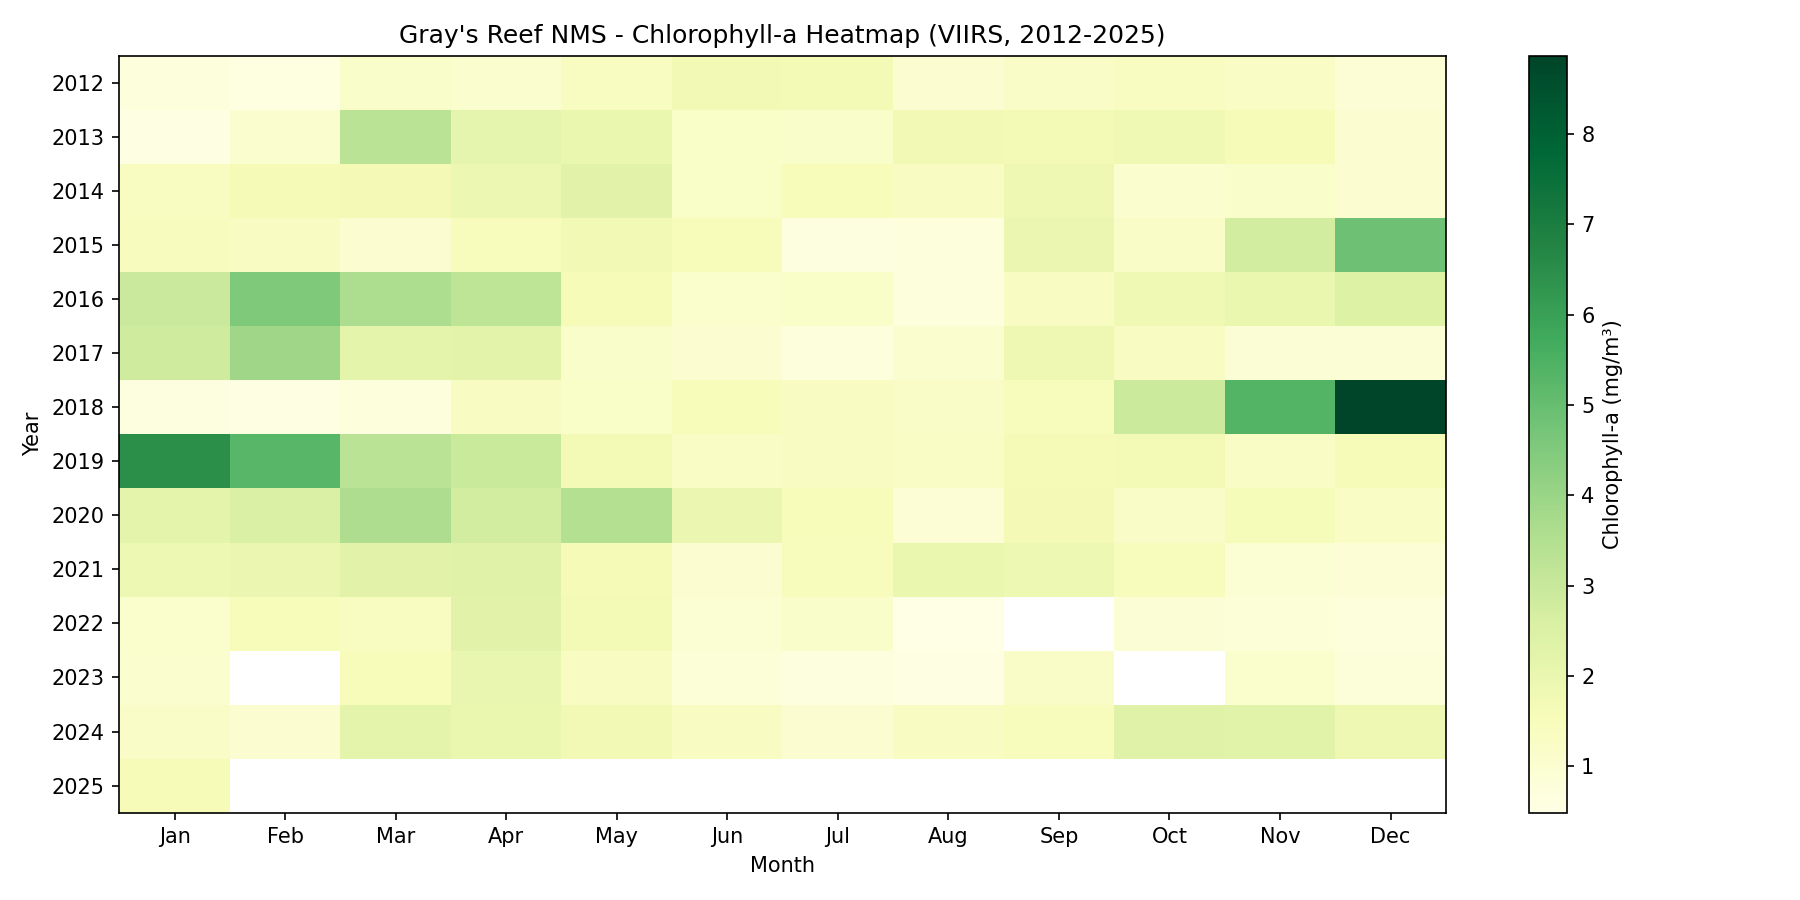

In [1]:
# Chlorophyll-a Seasonal Heatmap (2012-2024)
chla['year'] = chla['time'].dt.year
chla['month'] = chla['time'].dt.month
chla_pivot = chla.pivot_table(values='chlor_a', index='year', columns='month', aggfunc='mean')

fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(chla_pivot.values, cmap='YlGn', aspect='auto')
ax.set_xticks(range(12))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_yticks(range(len(chla_pivot.index)))
ax.set_yticklabels(chla_pivot.index)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Year', fontsize=12)
plt.colorbar(im, label='Chlorophyll-a (mg/m³)')
ax.set_title("Gray's Reef NMS - Chlorophyll-a Heatmap (2012-2024)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plot_chlorophyll_heatmap.png", dpi=150)
plt.show()

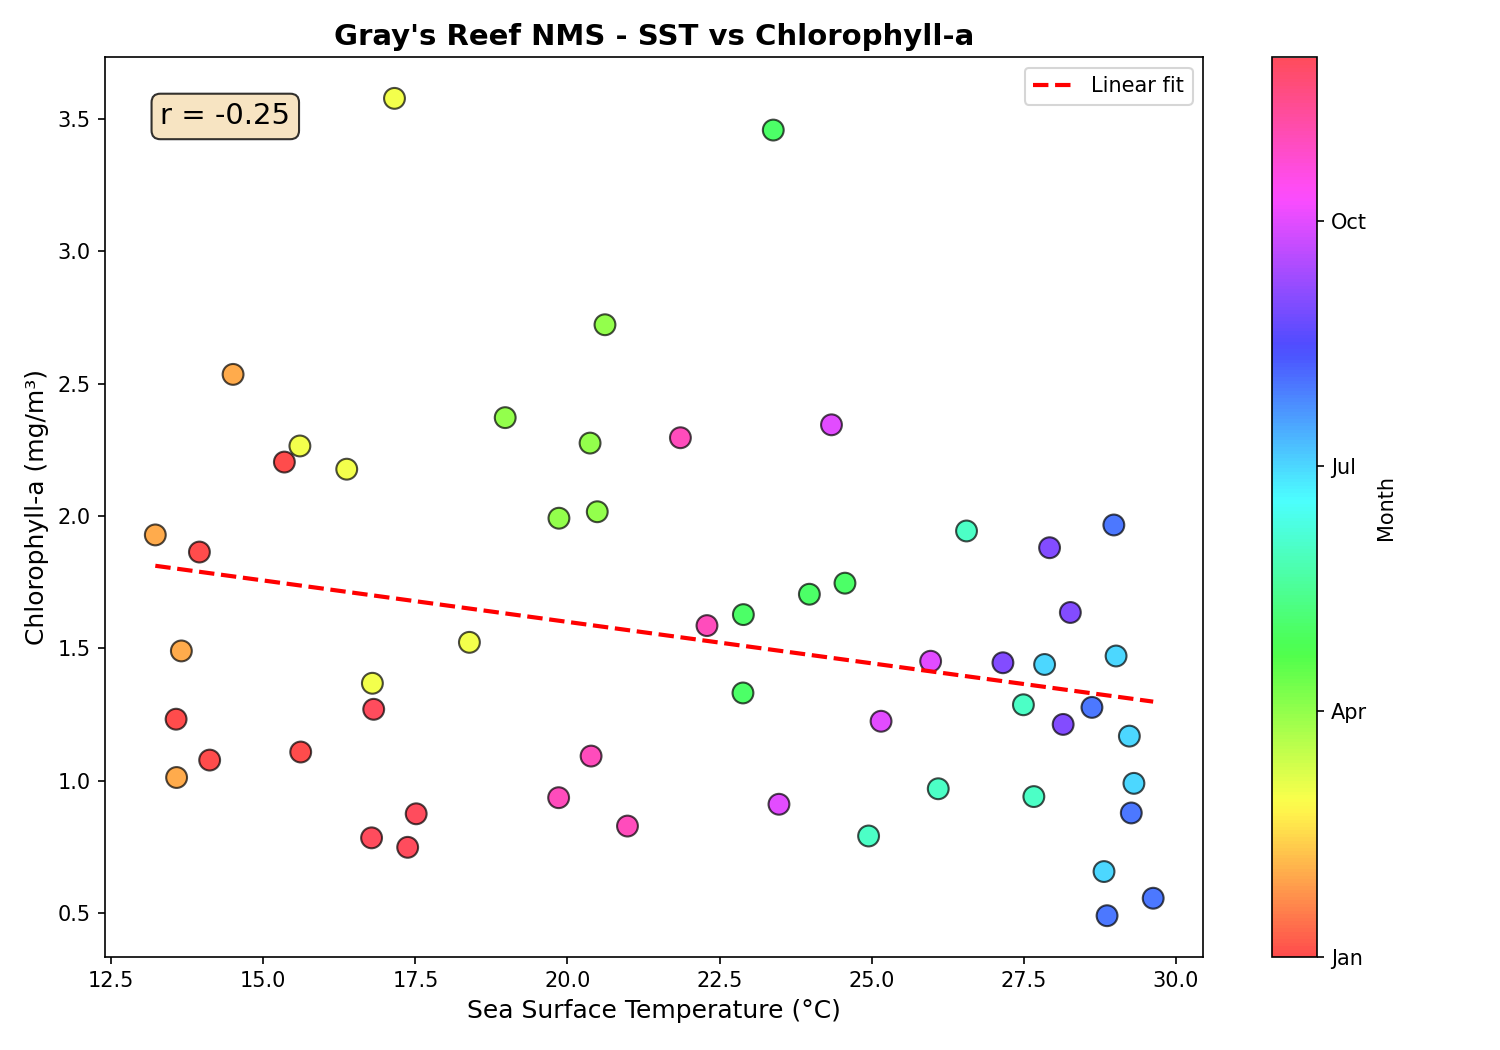

In [1]:
# SST vs Chlorophyll-a Relationship
# Merge datasets on year-month
sst['year_month'] = sst['time'].dt.to_period('M')
chla['year_month'] = chla['time'].dt.to_period('M')
merged = pd.merge(sst[['year_month', 'sea_surface_temperature']], 
                  chla[['year_month', 'chlor_a']], on='year_month')

fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(merged['sea_surface_temperature'], merged['chlor_a'], 
                     c=merged['year_month'].dt.month, cmap='hsv', s=100, alpha=0.7, edgecolor='black')
ax.set_xlabel('Sea Surface Temperature (°C)', fontsize=12)
ax.set_ylabel('Chlorophyll-a (mg/m³)', fontsize=12)
ax.set_title("Gray's Reef NMS - SST vs Chlorophyll-a", fontsize=14, fontweight='bold')

# Colorbar for months
cbar = plt.colorbar(scatter, ax=ax, label='Month')
cbar.set_ticks([1, 4, 7, 10])
cbar.set_ticklabels(['Jan', 'Apr', 'Jul', 'Oct'])

# Correlation and trend line
corr = merged['sea_surface_temperature'].corr(merged['chlor_a'])
ax.text(0.05, 0.95, f'r = {corr:.2f}', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

z = np.polyfit(merged['sea_surface_temperature'], merged['chlor_a'], 1)
p = np.poly1d(z)
x_line = np.linspace(merged['sea_surface_temperature'].min(), merged['sea_surface_temperature'].max(), 100)
ax.plot(x_line, p(x_line), 'r--', linewidth=2, label='Linear fit')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plot_sst_vs_chlorophyll.png", dpi=150)
plt.show()

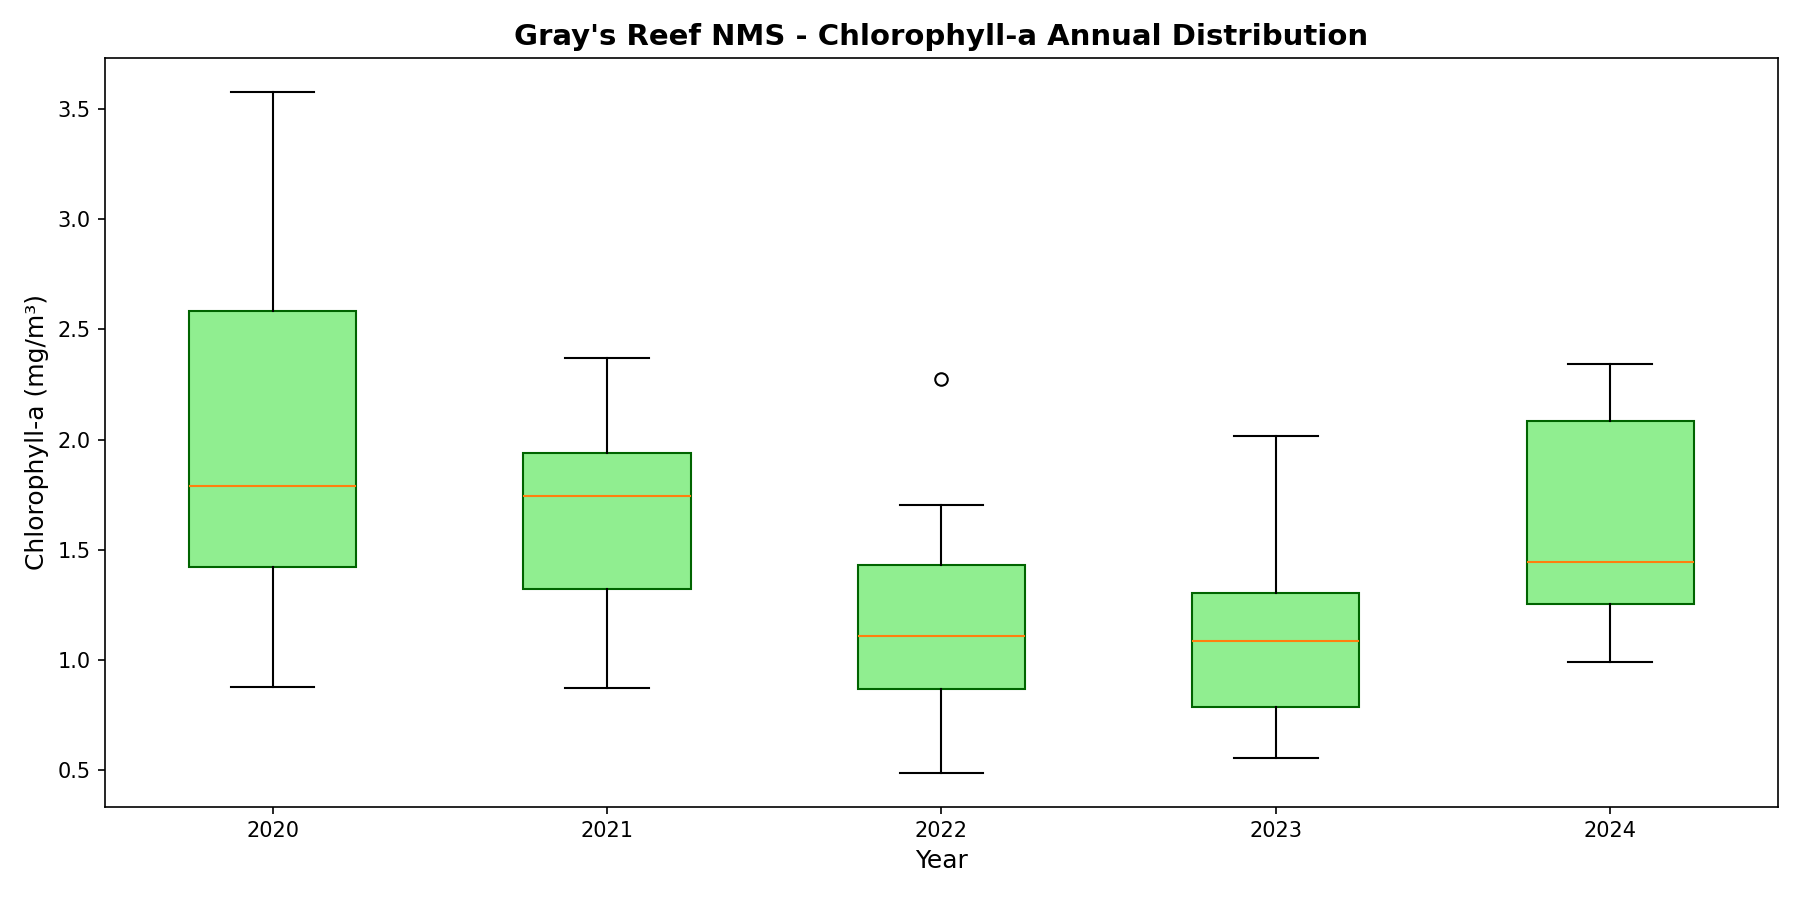

In [1]:
# Chlorophyll-a Annual Distribution (Boxplot)
years = sorted(chla['year'].unique())
data_by_year = [chla[chla['year'] == y]['chlor_a'].values for y in years]

fig, ax = plt.subplots(figsize=(12, 6))
bp = ax.boxplot(data_by_year, tick_labels=years, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightgreen')
    patch.set_edgecolor('darkgreen')
ax.set_ylabel('Chlorophyll-a (mg/m³)', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.set_title("Gray's Reef NMS - Chlorophyll-a Annual Distribution", fontsize=14, fontweight='bold')
ax.axhline(y=chla['chlor_a'].mean(), color='red', linestyle='--', label=f"Overall Mean: {chla['chlor_a'].mean():.2f}")
ax.legend()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plot_chlorophyll_boxplot.png", dpi=150)
plt.show()

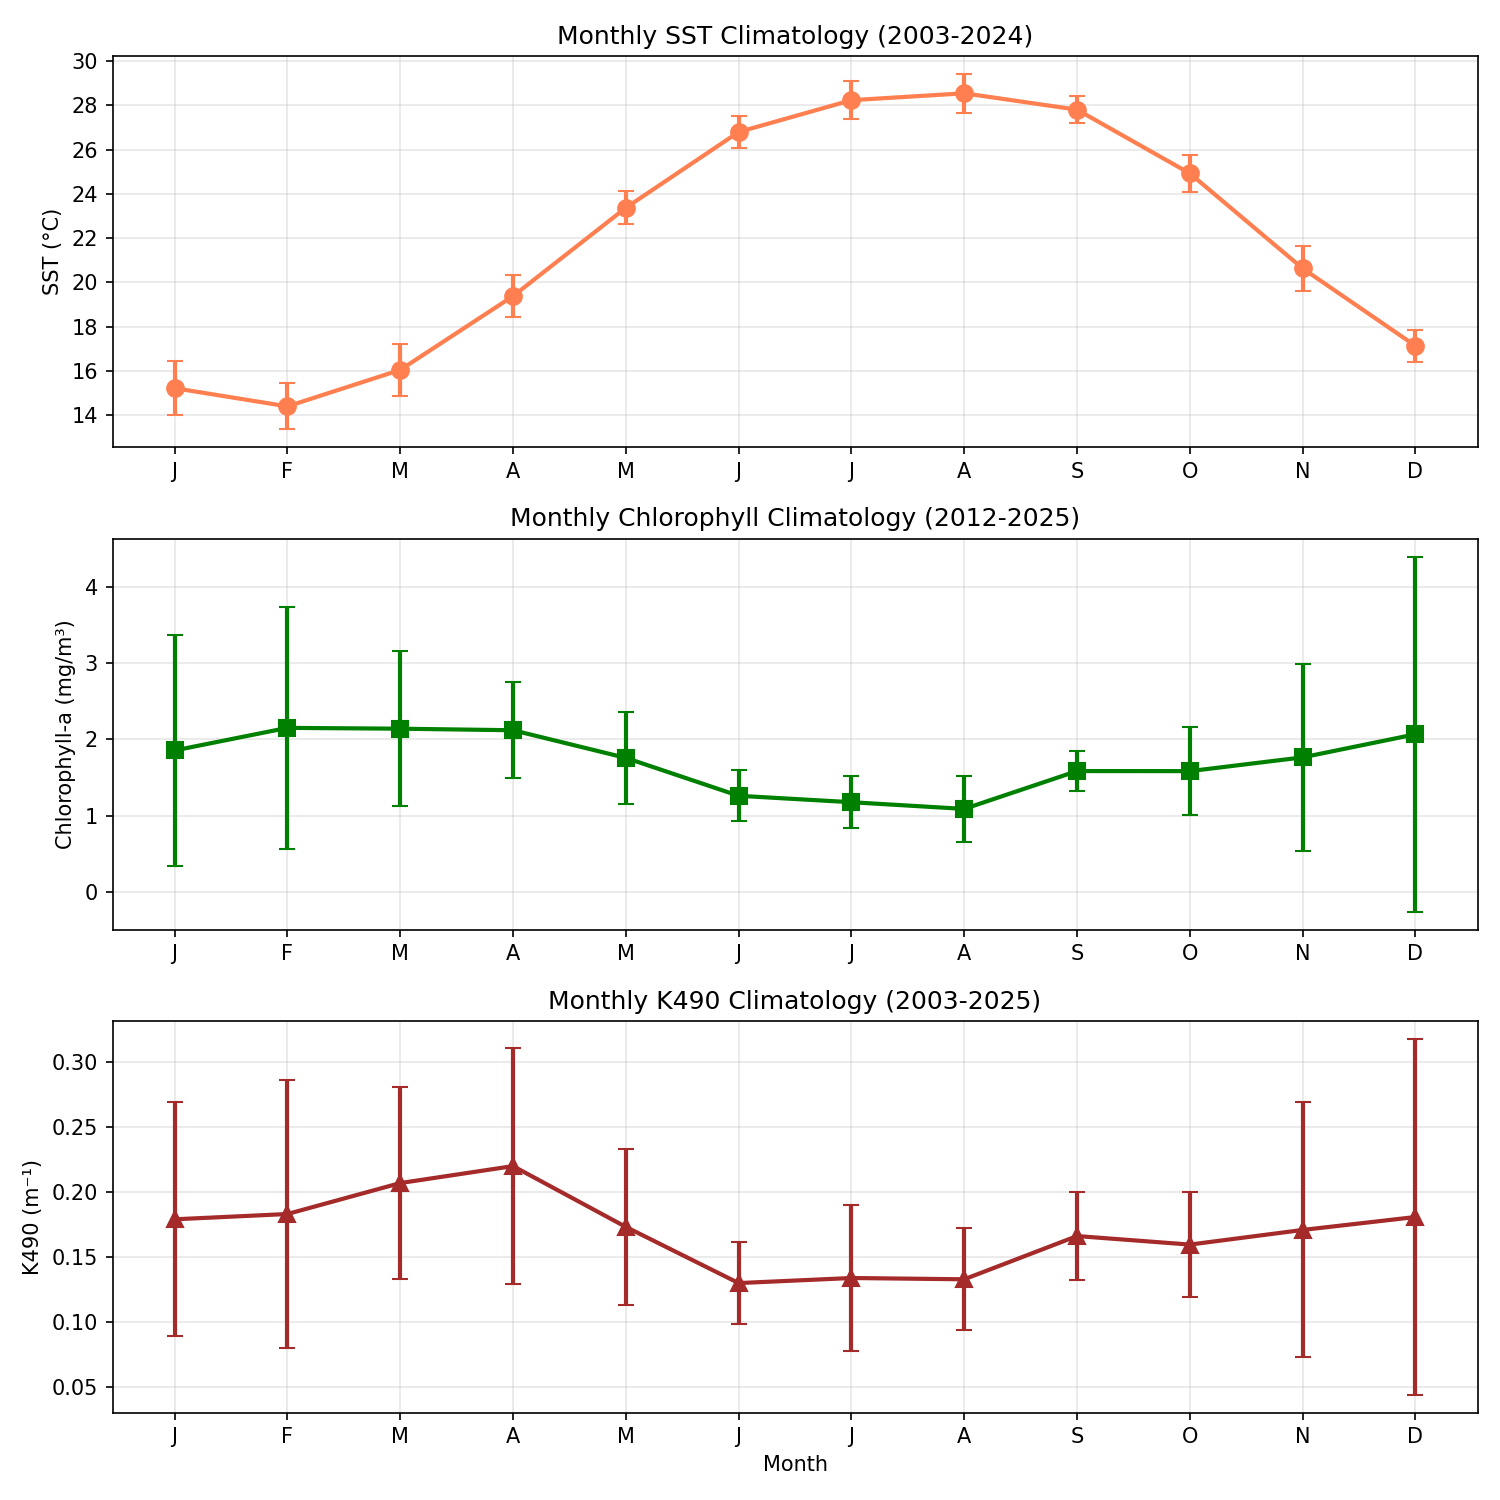

In [1]:
# Monthly Climatology (all three datasets)
sst['month'] = sst['time'].dt.month
k490['month'] = k490['time'].dt.month
chla['month'] = chla['time'].dt.month
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

# SST climatology (2003-2024)
sst_monthly = sst.groupby('month')['sea_surface_temperature'].agg(['mean','std'])
ax1.bar(sst_monthly.index, sst_monthly['mean'], yerr=sst_monthly['std'], 
        color='steelblue', capsize=4, alpha=0.8)
ax1.set_xticks(range(1,13))
ax1.set_xticklabels(months, rotation=45)
ax1.set_ylabel('Temperature (°C)')
ax1.set_title('SST Climatology\n(2003-2024)', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Chlorophyll climatology (2012-2024)
chla_monthly = chla.groupby('month')['chlor_a'].agg(['mean','std'])
ax2.bar(chla_monthly.index, chla_monthly['mean'], yerr=chla_monthly['std'],
        color='forestgreen', capsize=4, alpha=0.8)
ax2.set_xticks(range(1,13))
ax2.set_xticklabels(months, rotation=45)
ax2.set_ylabel('Chlorophyll-a (mg/m³)')
ax2.set_title('Chlorophyll-a Climatology\n(2012-2024)', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# K490 climatology (2003-2024)
k490_monthly = k490.groupby('month')['kd_490'].agg(['mean','std'])
ax3.bar(k490_monthly.index, k490_monthly['mean'], yerr=k490_monthly['std'],
        color='sienna', capsize=4, alpha=0.8)
ax3.set_xticks(range(1,13))
ax3.set_xticklabels(months, rotation=45)
ax3.set_ylabel('K490 (m⁻¹)')
ax3.set_title('K490 Climatology\n(2003-2024)', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

plt.suptitle("Gray's Reef NMS - Monthly Climatology", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plot_climatology.png", dpi=150, bbox_inches='tight')
plt.show()

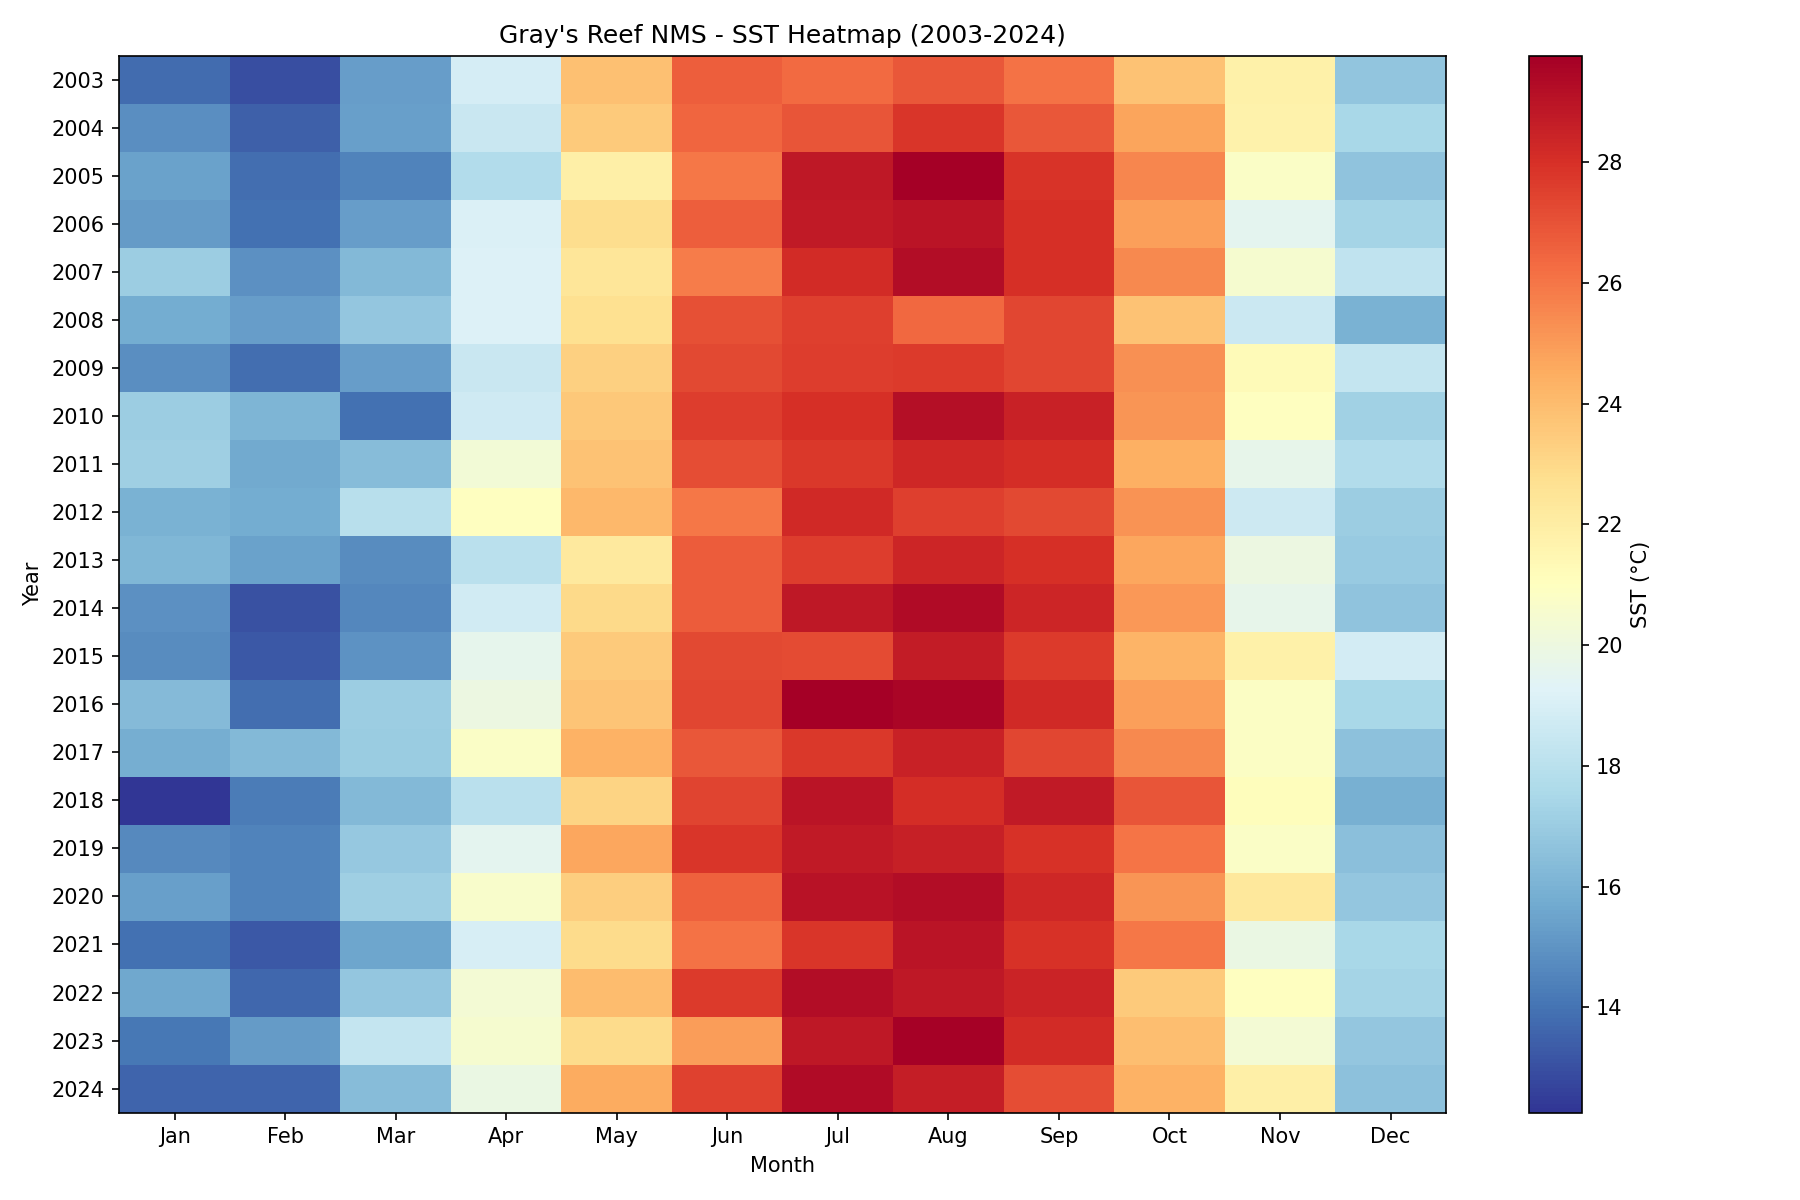

In [1]:
# SST Heatmap (2003-2024)
sst['year'] = sst['time'].dt.year
sst_pivot = sst.pivot_table(values='sea_surface_temperature', index='year', columns='month')

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(sst_pivot.values, cmap='RdYlBu_r', aspect='auto', vmin=12, vmax=30)
ax.set_xticks(range(12))
ax.set_xticklabels(months)
ax.set_yticks(range(len(sst_pivot.index)))
ax.set_yticklabels(sst_pivot.index)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Year', fontsize=12)
plt.colorbar(im, label='Temperature (°C)')
ax.set_title("Gray's Reef NMS - SST Heatmap (2003-2024)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plot_sst_heatmap.png", dpi=150)
plt.show()

---
## 8. Output Files

In [14]:
print("Output Files:")
print("="*50)
for f in sorted(os.listdir(OUTPUT_DIR)):
    size = os.path.getsize(os.path.join(OUTPUT_DIR, f)) / 1024
    print(f"{f:40} {size:>8.1f} KB")

Output Files:
annual_trends.png                            91.1 KB
data_summary.txt                              0.7 KB
environmental_analysis.png                  312.4 KB
grays_reef_location.png                     158.0 KB
k490_modis.csv                               26.2 KB
k490_modis_timeseries.csv                     1.9 KB
k490_raw.csv                                 26.8 KB
k490_timeseries.csv                           1.9 KB
plot_anomaly_distribution.png                54.5 KB
plot_climatology.png                         61.8 KB
plot_dashboard.png                          237.9 KB
plot_heatmap.png                             51.3 KB
plot_k490.png                                90.3 KB
plot_k490_timeseries.png                     96.3 KB
plot_monthly_climatology.png                 79.1 KB
plot_sst.png                                140.6 KB
plot_sst_heatmap.png                        101.5 KB
plot_sst_timeseries.png                     162.1 KB
seasonal_heatmaps.png           

---
## References

- **ERDDAP**: https://coastwatch.pfeg.noaa.gov/erddap/
- **Gray's Reef NMS**: https://graysreef.noaa.gov/
- **Coral Reef Watch**: https://coralreefwatch.noaa.gov/